# Contents
* [Library Imports](#library-imports)
* [Load and Split Dataset](#load-and-split)
    * [Loading](#loading)
    * [Splitting](#splitting)
* [Exploration + Visualizations](#exploration-and-visualization)
* [Baseline](#baseline)
    * [Preprocess](#preprocess)
    * [Train](#train1)
    * [Results](#results1)
* [Model v1](#model-v1)
    * [Train](#train2)
    * [Results](#results2)
    * [Prediction Explanations](#prediction-explanations)
* [Image Augmentation](#image-augmentation)
* [Model v2](#model-v2)
    * [Train](#train3)
    * [Results](#results3)
* [Reflection Checkpoint](#reflection-checkpoint)
* [Model v2.1](#model-v2.1)
    * [Train](#train4)
    * [Results](#results4)
* [Reflections](#reflections)

# Library Imports <a class="anchor" id="library-imports"></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix
import pandas as pd

2023-11-20 19:02:28.253143: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 19:02:28.318195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 19:02:28.318271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 19:02:28.318502: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 19:02:28.348917: I tensorflow/core/platform/cpu_feature_g

# Load and Split Dataset <a class="anchor" id="load-and-split"></a>

## Loading <a class="anchor" id="loading"></a>

In [2]:
dataset, dataset_info = tfds.load(
    'bee_dataset',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
dataset_info

2023-11-20 19:02:33.031756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 19:02:33.054242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 19:02:33.054269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 19:02:33.056858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 19:02:33.056890: I tensorflow/compile

tfds.core.DatasetInfo(
    name='bee_dataset',
    full_name='bee_dataset/bee_dataset_300/1.0.0',
    description="""
    This dataset contains images and a set of labels that expose certain
    characterisitics of that images, such as *varroa-mite* infections, bees carrying
    *pollen-packets* or bee that are *cooling the hive* by flappingn their wings.
    Additionally, this dataset contains images of *wasps* to be able to distinguish
    bees and wasps.
    
    The images of the bees are taken from above and rotated. The bee is vertical and
    either its head or the trunk is on top. All images were taken with a green
    background and the distance to the bees was always the same, thus all bees have
    the same size.
    
    Each image can have multiple labels assigned to it. E.g. a bee can be cooling
    the hive and have a varrio-mite infection at the same time.
    
    This dataset is designed as mutli-label dataset, where each label, e.g.
    *varroa_output*, contains 1 if

In [3]:
type(dataset[0])

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

## Splitting <a class="anchor" id="splitting"></a>
We'll do this before any other steps to avoid biasing the mdoel toward the test set.

In [4]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size).cache()  
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
train, val, test = get_dataset_partitions_tf(dataset[0], dataset_info.splits['train'].num_examples, shuffle=True)

In [6]:
train

<CacheDataset element_spec=(TensorSpec(shape=(300, 150, 3), dtype=tf.uint8, name=None), {'cooling_output': TensorSpec(shape=(), dtype=tf.float64, name=None), 'pollen_output': TensorSpec(shape=(), dtype=tf.float64, name=None), 'varroa_output': TensorSpec(shape=(), dtype=tf.float64, name=None), 'wasps_output': TensorSpec(shape=(), dtype=tf.float64, name=None)})>

# Exploration + Visualizations <a class="anchor" id="exploration-and-visualization"></a>

In [7]:
def display_sample_images(dataset, n_samples=5):
    plt.figure(figsize=(15, 5))
    for i, (image, output) in enumerate(dataset.take(n_samples)):
        ax = plt.subplot(1, n_samples, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Sample {i+1}")
        plt.axis("off")

        feature_text = (f"Cooling: {output['cooling_output'].numpy():.2f}\n"
                        f"Pollen: {output['pollen_output'].numpy():.2f}\n"
                        f"Varroa: {output['varroa_output'].numpy():.2f}\n"
                        f"Wasps: {output['wasps_output'].numpy():.2f}")

        # Display the text below the image
        plt.text(0, image.numpy().shape[0] + 20, feature_text, ha='left', va='top')
        plt.subplots_adjust(hspace=0.5)
    plt.show()

2023-11-17 16:34:25.625798: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


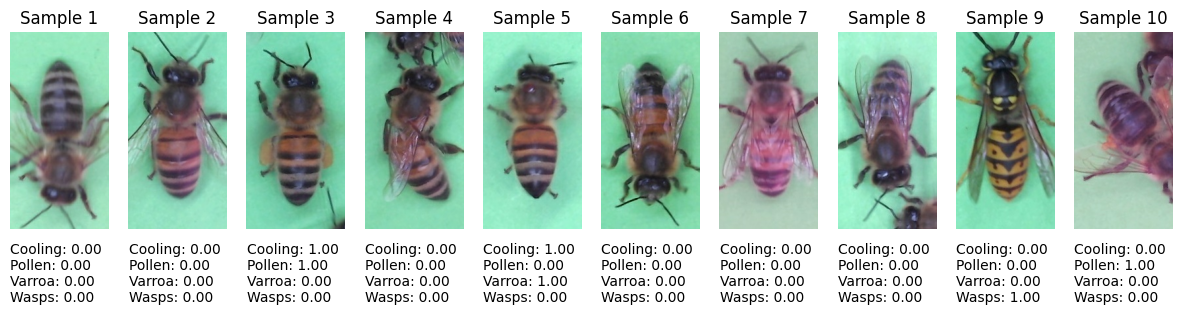

In [8]:
display_sample_images(train, 10)

In [9]:
def plot_output_distribution(dataset, feature_name):
    values = [output[feature_name].numpy() for _, output in dataset]
    plt.hist(values, bins=30)
    plt.title(f"Distribution of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Frequency")
    plt.show()

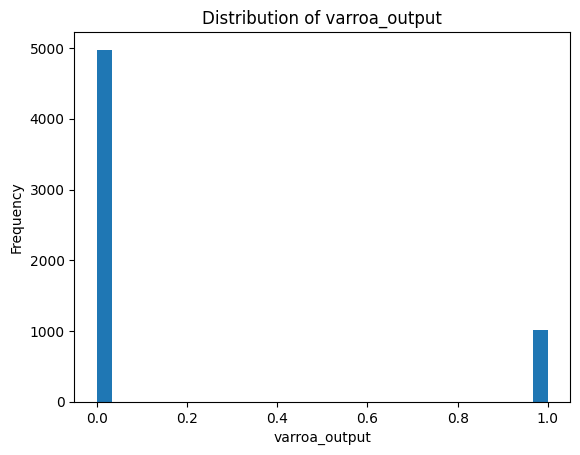

In [10]:
plot_output_distribution(train, "varroa_output")

**Note:** Looks like a large class imbalance for the varroa feature so may need to do something to that later on.

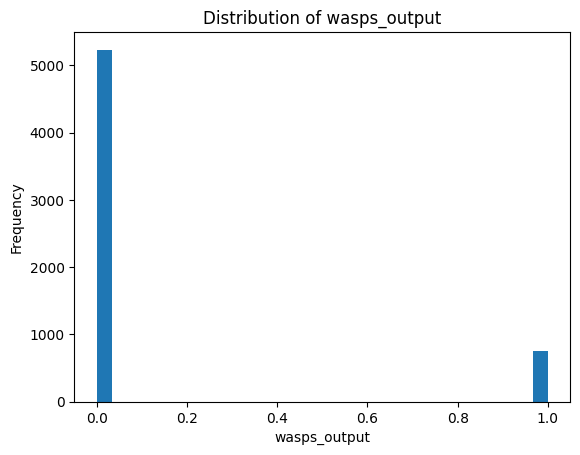

In [11]:
plot_output_distribution(train, "wasps_output")

In [12]:
def plot_combination_distribution(dataset, feature1, feature2):
    data = [(output[feature1].numpy(), output[feature2].numpy()) for _, output in dataset]
    df = pd.DataFrame(data, columns=[feature1, feature2])

    combination_counts = pd.crosstab(df[feature1], df[feature2])

    sns.heatmap(combination_counts, annot=True, cmap="YlGnBu", fmt="d")
    plt.title(f"Distribution of Combinations of {feature1} and {feature2}")
    plt.xlabel(feature2)
    plt.ylabel(feature1)
    plt.show()

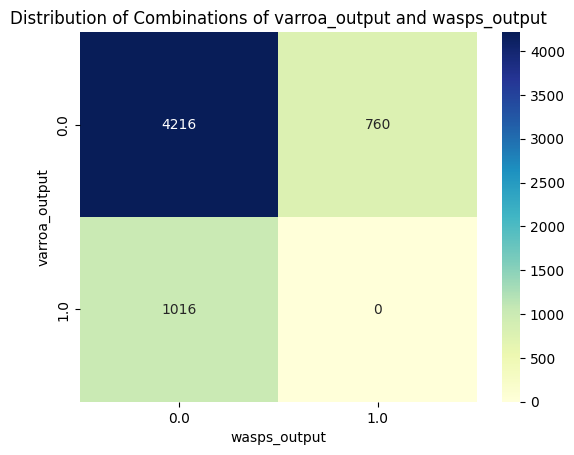

In [13]:
plot_combination_distribution(train, 'varroa_output', 'wasps_output')

Okay so we know there's a large class imbalance in favour of bees without varroa in the dataset. We also know that if the image is wasp there are no varroa outputs so they're not completely indepenedent. I also think the shape of the bee will be important when looking for the varroa because the model SHOULD be looking at the bee for the varroa. Based on this, I think starting with a multi-ouptut model makes a lot of sense since the model will benefit from the underlying knowledge of bee vs wasp to predict varroa.

For fun we'll look at the average color distribution for those two features as well since I could see that largely affecting the wasp predictions and probably affecting the varroa predictions. If any of the averages are largely off and the model is struggling with certain examples I can play around with colour in an augmented dataset.

In [14]:
def plot_color_distributions(dataset, feature_name):
    avg_red_0, avg_green_0, avg_blue_0 = [], [], []
    avg_red_1, avg_green_1, avg_blue_1 = [], [], []

    for image, output in dataset:
        avg_red, avg_green, avg_blue = np.mean(image.numpy(), axis=(0, 1))
        
        if output[feature_name].numpy() == 0:
            avg_red_0.append(avg_red)
            avg_green_0.append(avg_green)
            avg_blue_0.append(avg_blue)
        else:
            avg_red_1.append(avg_red)
            avg_green_1.append(avg_green)
            avg_blue_1.append(avg_blue)

    # Plotting
    colors = ['Red', 'Green', 'Blue']
    for i, (color_values_0, color_values_1) in enumerate(zip([avg_red_0, avg_green_0, avg_blue_0], 
                                                             [avg_red_1, avg_green_1, avg_blue_1])):
        plt.figure(figsize=(10, 4))

        # Plot for feature value 0
        plt.subplot(1, 2, 1)
        plt.hist(color_values_0, bins=30, color=colors[i].lower(), alpha=0.7)
        plt.title(f"{colors[i]} Distribution (Feature = 0)")
        plt.xlabel(f"Average {colors[i]} Value")
        plt.ylabel("Frequency")

        # Plot for feature value 1
        plt.subplot(1, 2, 2)
        plt.hist(color_values_1, bins=30, color=colors[i].lower(), alpha=0.7)
        plt.title(f"{colors[i]} Distribution (Feature = 1)")
        plt.xlabel(f"Average {colors[i]} Value")
        plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()

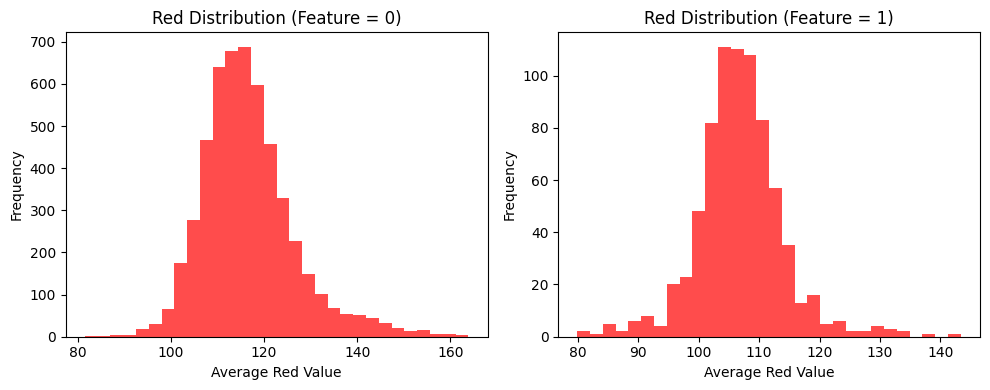

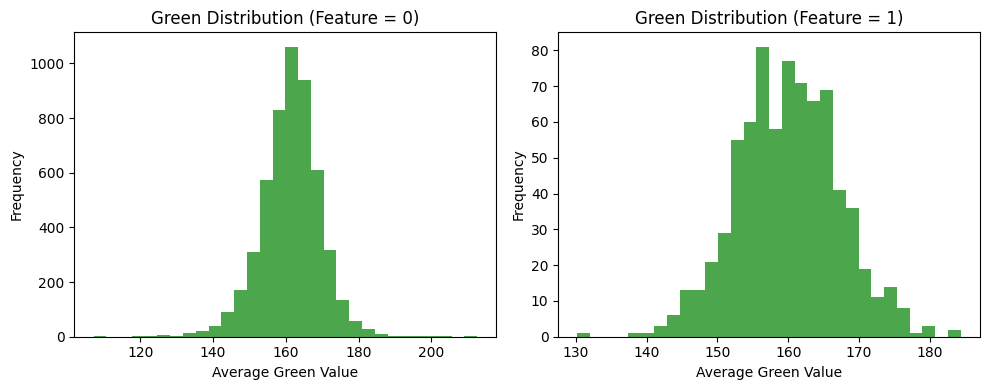

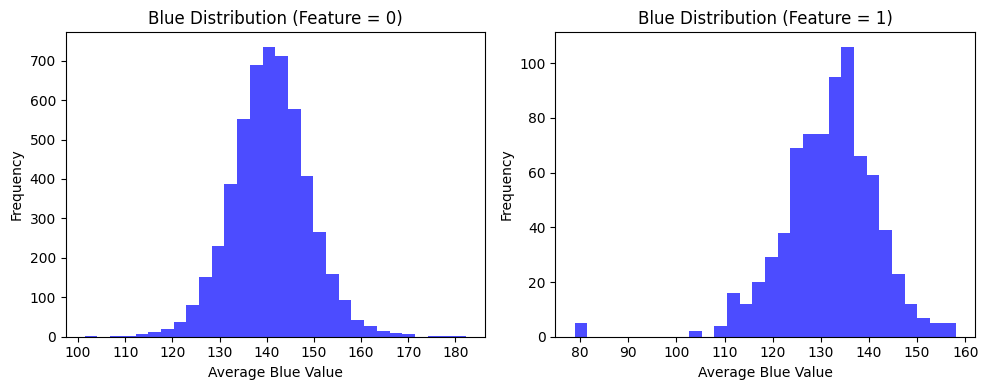

In [15]:
plot_color_distributions(train, "wasps_output")

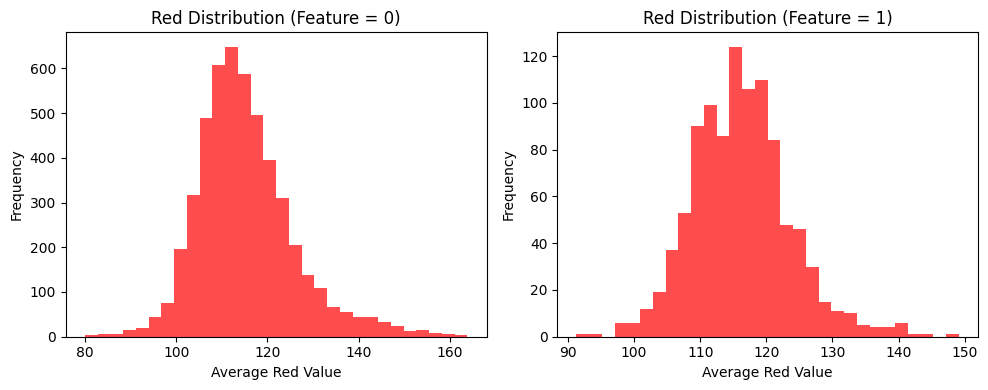

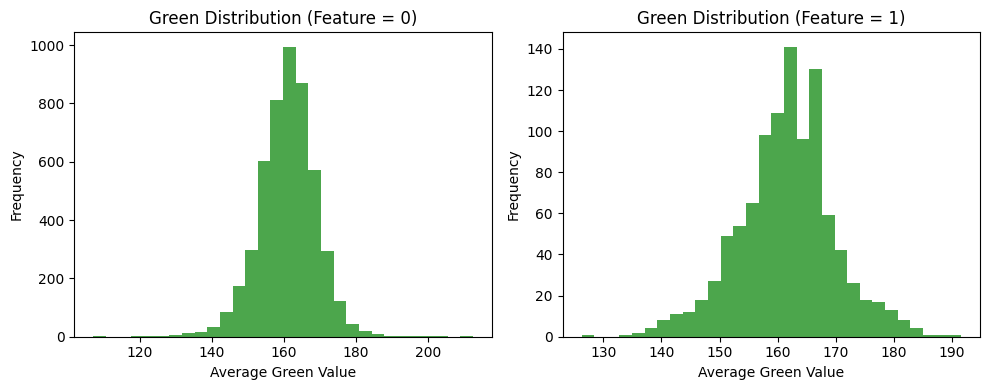

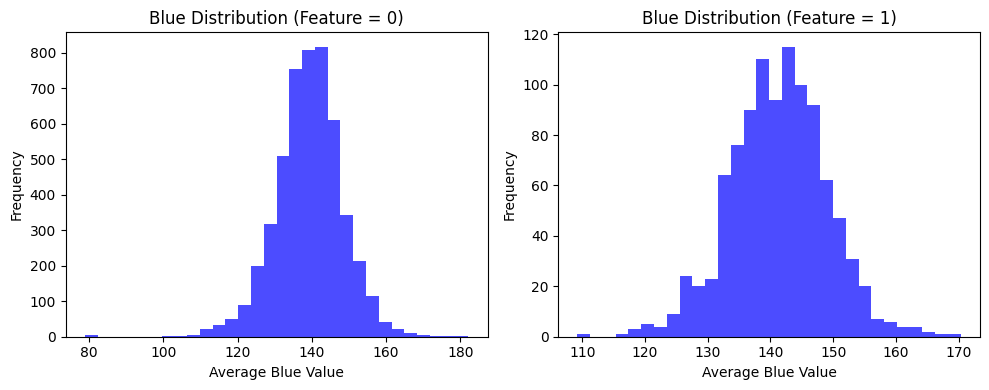

In [16]:
plot_color_distributions(train, "varroa_output")

I don't see any huge variations in the values other than slightly lower average reds for wasp images. This could be because the bee 'yellow' is much more orange, which would mean higher values in the red channel. I'll try to add some small corrections in this in the model by playing around with saturation and colour shifting in augmentations but overall the effect wasn't as large as I thought it could be.

## Preprocess <a class="anchor" id="preprocess"></a>

In [17]:
def extract_features(image, output_dict):
    # Extract only the 'varroa_output' and 'wasps_output'
    selected_outputs = tf.stack([output_dict['varroa_output'], output_dict['wasps_output']], axis=-1)
    return image, selected_outputs

In [18]:
batch_size=32
train = train.map(extract_features).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val = val.map(extract_features).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [19]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 150, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

# Baseline <a class="anchor" id="baseline"></a>
We'll start by trying to use just a raw version of one of the higher performing ResNet models and then we can start exploring augmentation, etc. To start we'll train only a custom head with the rest of the model frozen.

## Train <a class="anchor" id="train1"></a>

In [20]:
# Load the pre-trained ResNetRS350 model
base_model = tf.keras.applications.resnet_rs.ResNetRS350(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 150, 3)
)

# Freeze the layers of the base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units
predictions = Dense(2, activation='sigmoid')(x)  # 2 units for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train, validation_data=val, epochs=30, callbacks=[callback], verbose=1)

In [ ]:
# Note: using the SavedModel format because I'm havign issues with the new .keras format hanging on load
model.save('models/model')

## (Optionally: Load)

In [21]:
model = tf.keras.models.load_model('models/model')

## Results <a class="anchor" id="results1"></a>
We'll start by just checking a single sample to see the image and actual vs predicted labels sample 

2023-11-17 16:12:42.774121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


1/1 [==============================] - 6s 6s/step


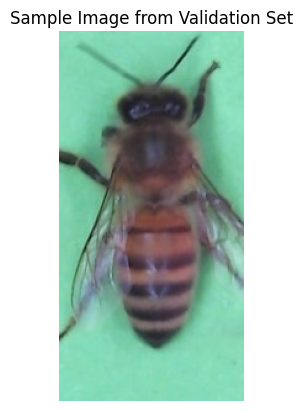

Actual Labels:  [0. 0.]
Predicted Labels:  [0. 0.]


In [22]:
# Take one batch from the validation dataset
for images, labels in val.take(1):
    # Make predictions on this batch
    predictions = model.predict(images)

    # Select the first image from the batch
    image = images[0].numpy()
    actual_labels = labels[0].numpy()
    predicted_labels = np.rint(predictions[0])

    # Display the image
    plt.imshow(image)
    plt.title("Sample Image from Validation Set")
    plt.axis('off')
    plt.show()

    # Display the actual and predicted features
    print("Actual Labels: ", actual_labels)
    print("Predicted Labels: ", predicted_labels)

Looks good so let's actually perform some evaluation on the validation set. We're going to save the test set for the very end after we've selected the best methods and model and fine tuned it to get a real-world view of how well our model would perform.

In [22]:
def get_predictions(model, dataset, threshold=0.5):
    y_true = []
    y_pred = []

    for batch in dataset:
        inputs, labels = batch
        predictions = model.predict(inputs)
        y_true.append(labels)
        y_pred.append(predictions)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    y_pred = (y_pred >= threshold).astype(int)

    return y_true, y_pred

In [24]:
y_true, y_pred = get_predictions(model, val, 0.5)

1/1 [==============================] - 4s 4s/step


In [25]:
incorrect = np.sum(y_pred != y_true)
print(f"Total Incorrect Predictions: {incorrect}/{np.shape(y_pred)[0]}")

Total Incorrect Predictions: 88/749


In [26]:
output_list = ['Varroa', 'Wasp']

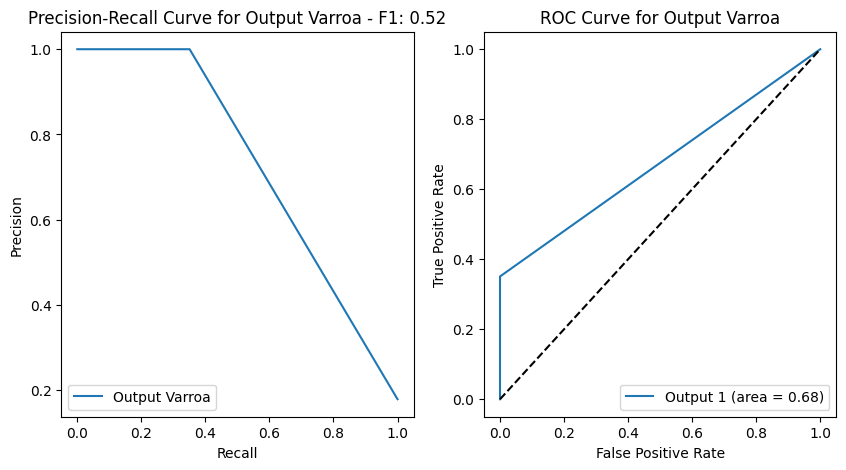

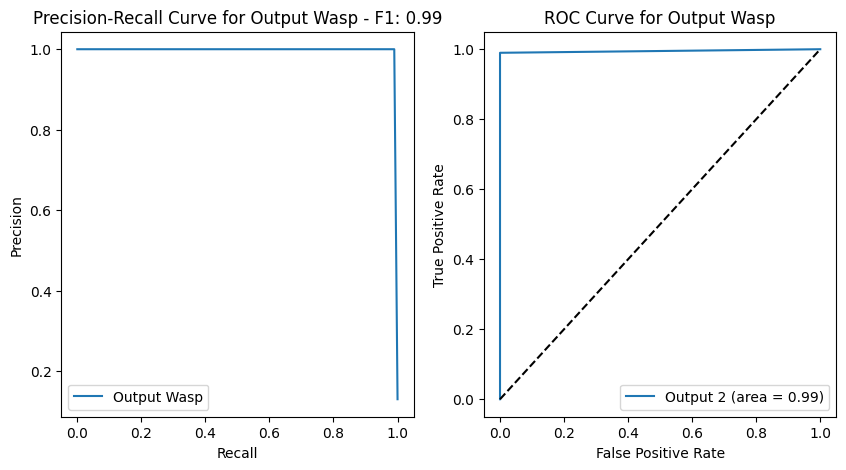

In [27]:
# Calculate metrics for each output
for i in range(2):
    # Precision, Recall, and F1 Score
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    f1 = f1_score(y_true[:, i], np.round(y_pred[:, i]))

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    # Visualization
    plt.figure(figsize=(10, 5))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'Output {output_list[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Output {output_list[i]} - F1: {f1:.2f}')
    plt.legend(loc="lower left")

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'Output {i+1} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Output {output_list[i]}')
    plt.legend(loc="lower right")

    plt.show()

Looks like we're super good at predicting wasps and performimg okay with varroa, although I think there's quite a bit of space for improvement. We'll dive in a little deeper to see if we can find where the model is struggling but I think one of the first things I'll try to address is the class imbalance, probably by trying a different loss function to start.

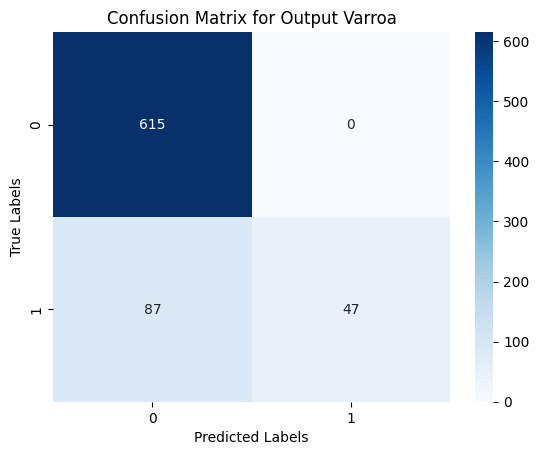

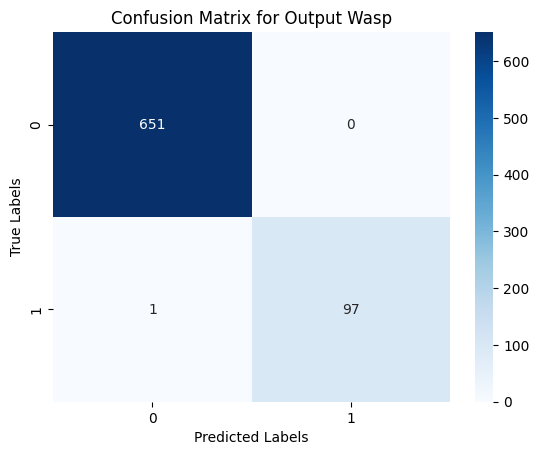

In [30]:
for i in range(2):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Output {output_list[i]}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [28]:
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

threshold = 0.5  # Define your threshold

for images, labels in val:
    preds = model.predict(images)
    preds_binary = (preds >= threshold).astype(int)

    # Identify incorrect predictions
    incorrect_indices = np.where(np.any(preds_binary != labels, axis=1))[0]

    for i in incorrect_indices:
        incorrect_images.append(images[i])
        incorrect_labels.append(labels[i])
        incorrect_predictions.append(preds_binary[i])

1/1 [==============================] - 0s 65ms/step


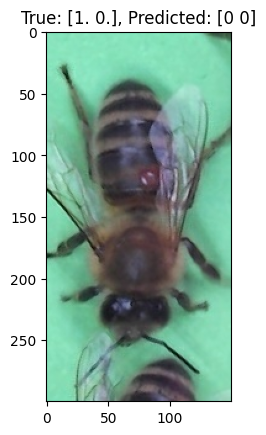

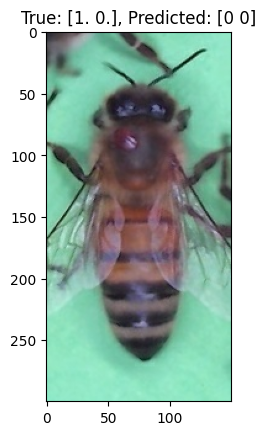

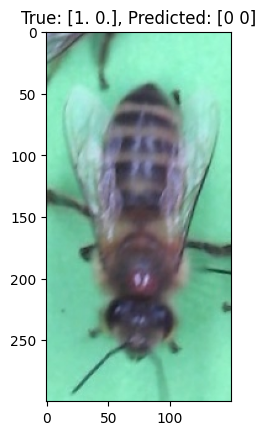

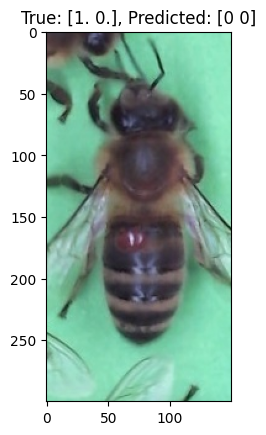

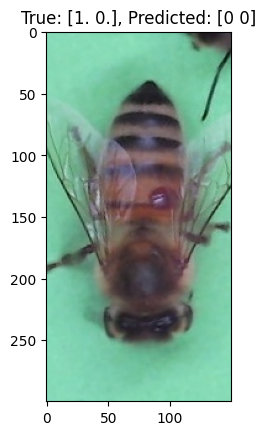

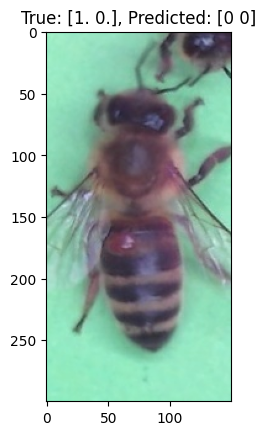

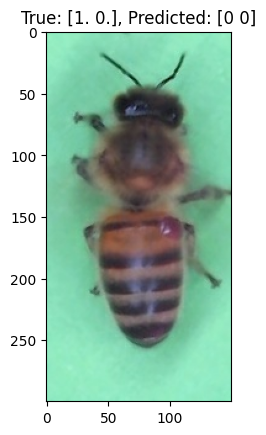

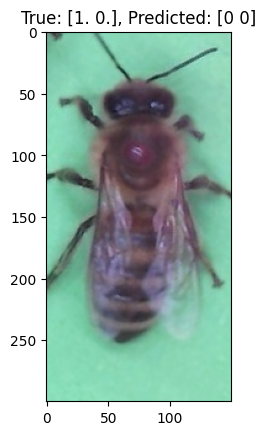

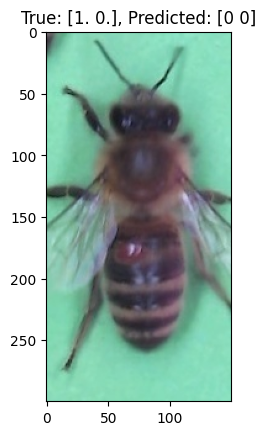

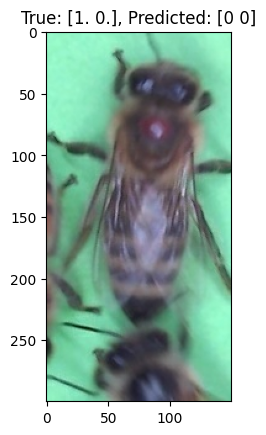

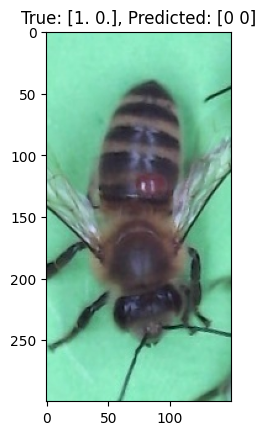

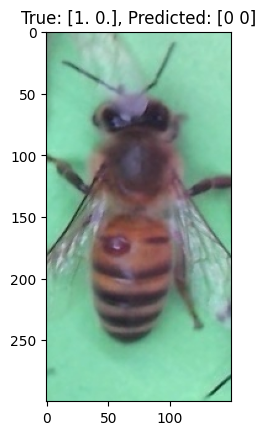

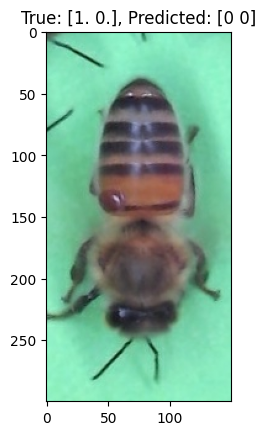

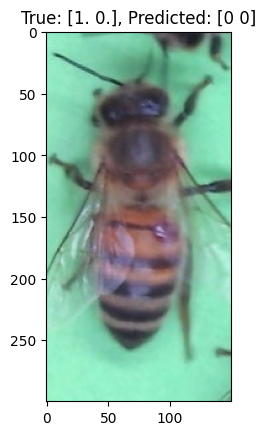

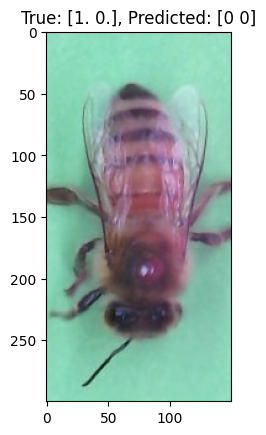

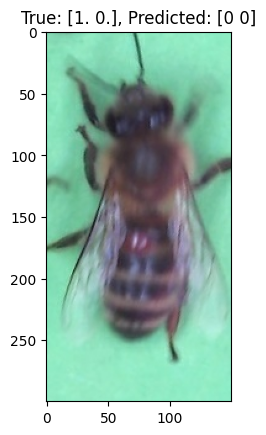

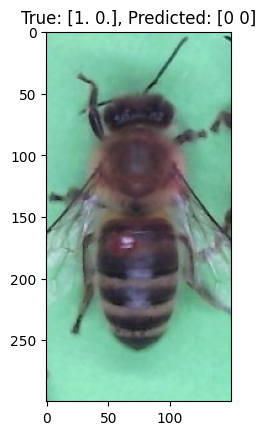

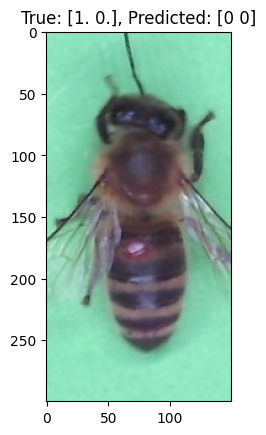

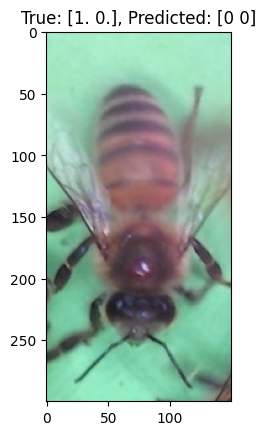

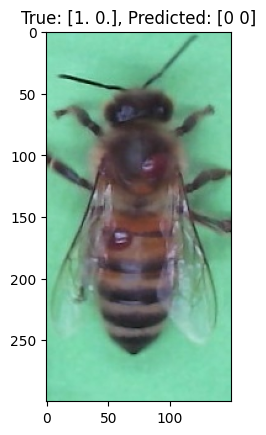

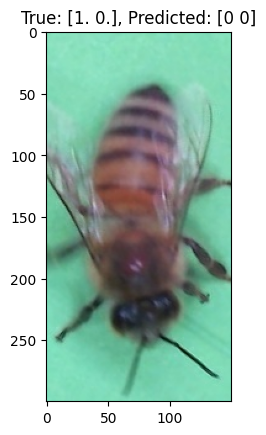

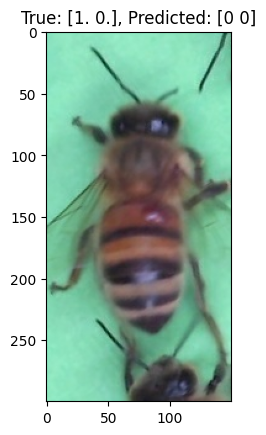

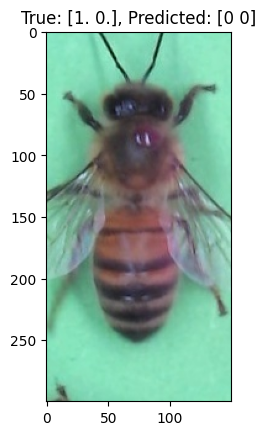

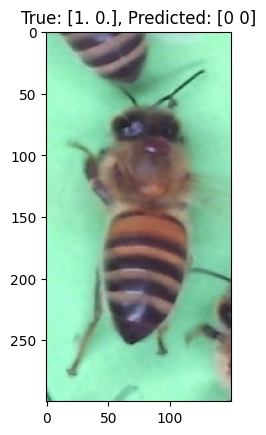

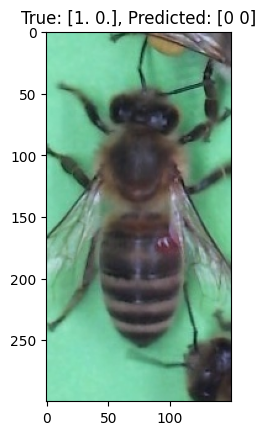

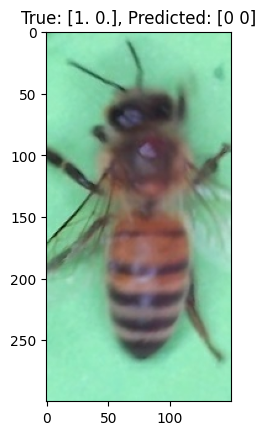

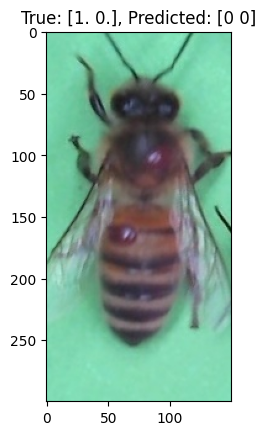

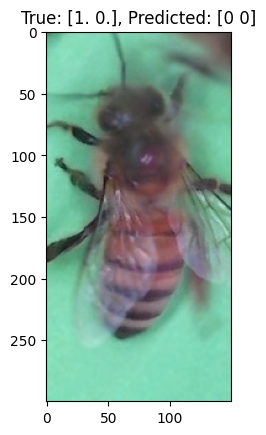

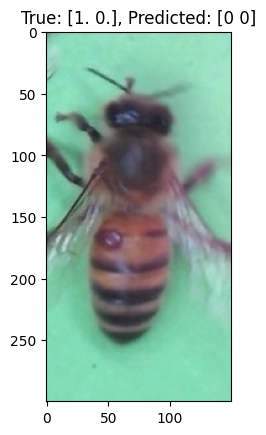

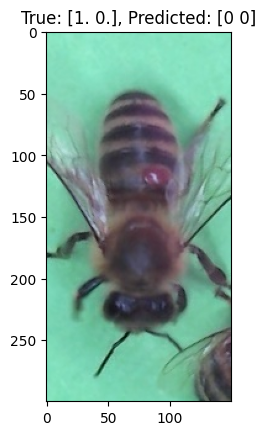

In [31]:
# Display first N incorrect images
N = 30
for i in range(min(N, len(incorrect_images))):
    plt.imshow(incorrect_images[i])
    plt.title(f"True: {incorrect_labels[i]}, Predicted: {incorrect_predictions[i]}")
    plt.show()

These are all pretty clear examples of varroa so the model really doesn't seem to be catching onto it very well. Some more exploration showed the one "wasp" picture probbaly wasn't an actual wasp and was just mislabeled so I think we're pretty good in terms of differentiating.

# Model v1 <a class="anchor" id="model-v1"></a>

## Train <a class="anchor" id="train2"></a>

In [59]:
from tensorflow.keras.losses import BinaryFocalCrossentropy

# Load the pre-trained ResNetRS350 model
base_model = tf.keras.applications.resnet_rs.ResNetRS350(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 150, 3)
)

# Freeze the layers of the base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units
predictions = Dense(2, activation='sigmoid')(x)  # 2 units for binary classification

# Create the final model
model_v1 = Model(inputs=base_model.input, outputs=predictions)

focal_loss = BinaryFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=False)

# Compile the model
model_v1.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model_v1.fit(train, validation_data=val, epochs=30, callbacks=[callback], verbose=1)

In [ ]:
model_v1.save('models/model_v1')

## Load

In [32]:
model_v1 = tf.keras.models.load_model('models/model_v1')

# Results <a class="anchor" id="results2"></a>

In [33]:
y_true, y_pred = get_predictions(model_v1, val, 0.5)

incorrect = np.sum(y_pred != y_true)
print(f"Total Incorrect Predictions: {incorrect}/{np.shape(y_pred)[0]}")

1/1 [==============================] - 3s 3s/step
Total Incorrect Predictions: 27/749


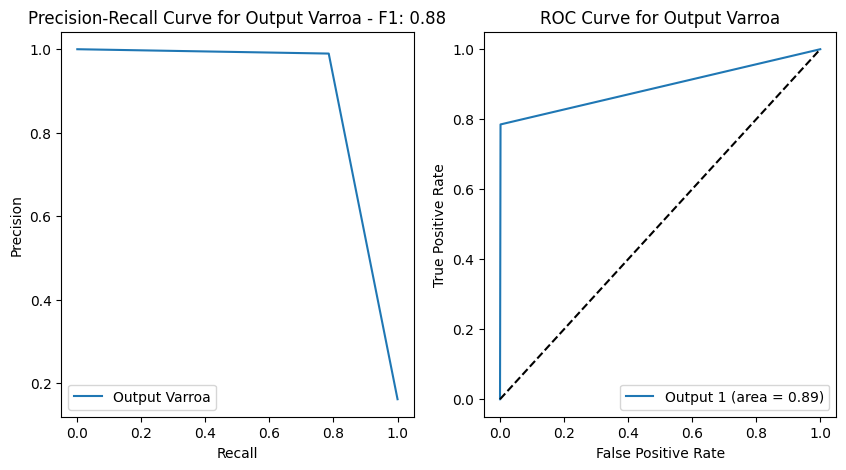

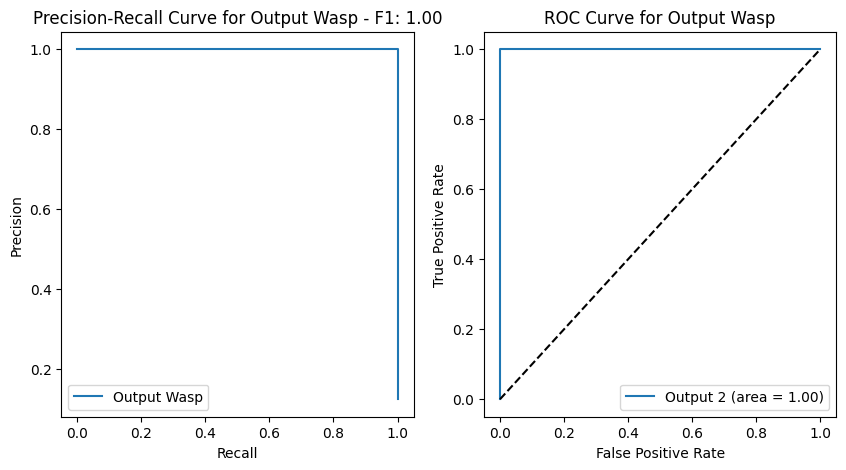

In [34]:
# Calculate metrics for each output
for i in range(2):
    # Precision, Recall, and F1 Score
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    f1 = f1_score(y_true[:, i], np.round(y_pred[:, i]))

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    # Visualization
    plt.figure(figsize=(10, 5))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'Output {output_list[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Output {output_list[i]} - F1: {f1:.2f}')
    plt.legend(loc="lower left")

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'Output {i+1} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Output {output_list[i]}')
    plt.legend(loc="lower right")

    plt.show()

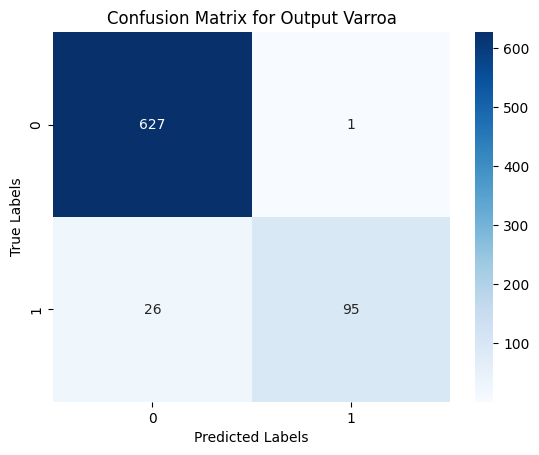

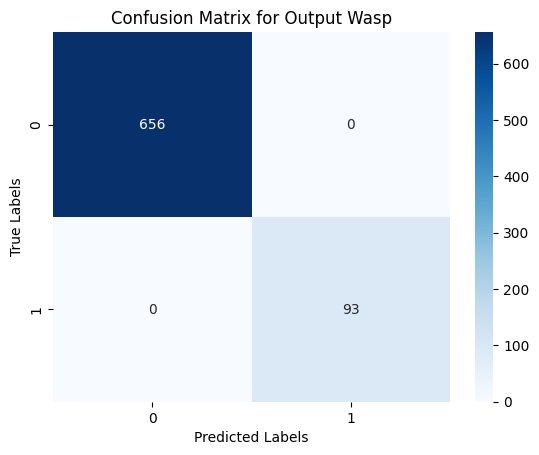

In [35]:
for i in range(2):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Output {output_list[i]}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [37]:
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

threshold = 0.5  # Define your threshold

for images, labels in val:
    preds = model_v1.predict(images)
    preds_binary = (preds >= threshold).astype(int)

    # Identify incorrect predictions
    incorrect_indices = np.where(np.any(preds_binary != labels, axis=1))[0]

    for i in incorrect_indices:
        incorrect_images.append(images[i])
        incorrect_labels.append(labels[i])
        incorrect_predictions.append(preds_binary[i])

1/1 [==============================] - 0s 63ms/step


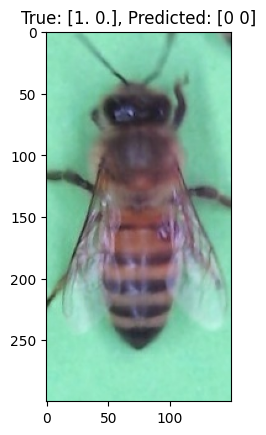

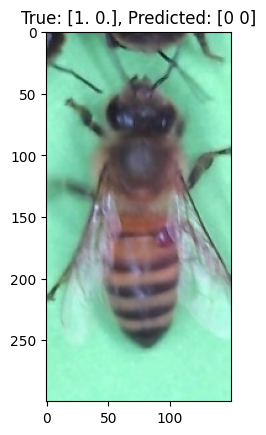

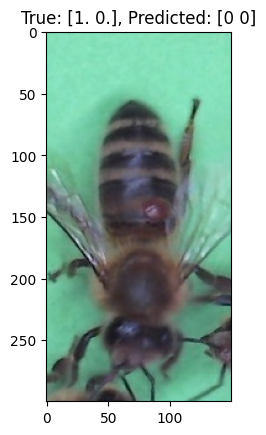

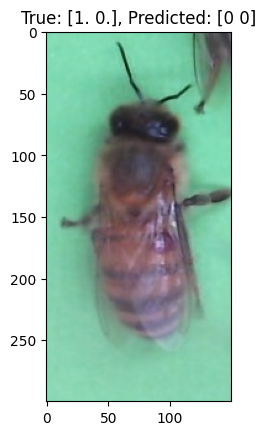

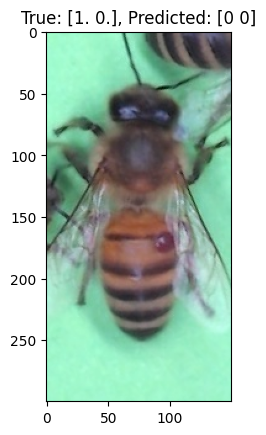

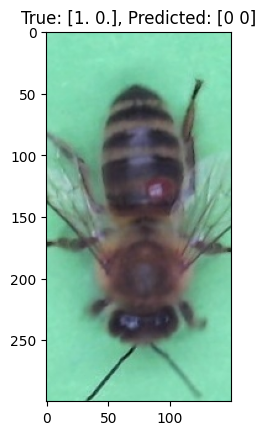

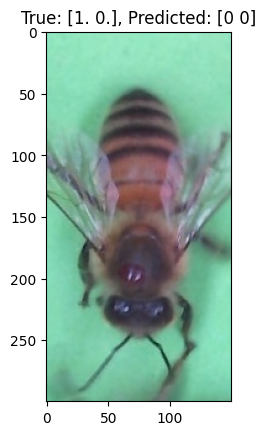

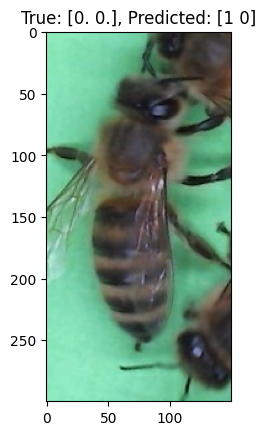

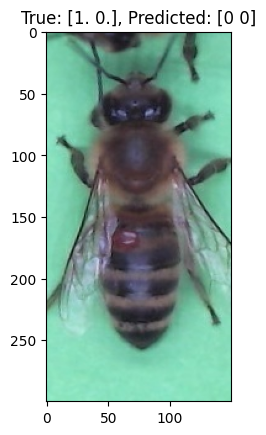

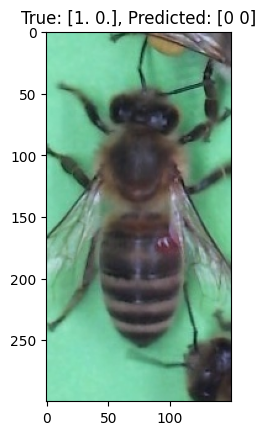

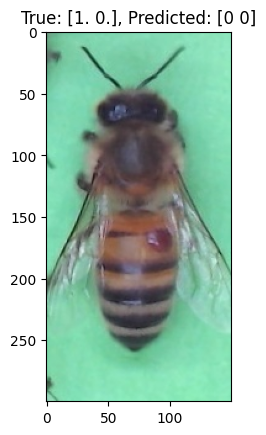

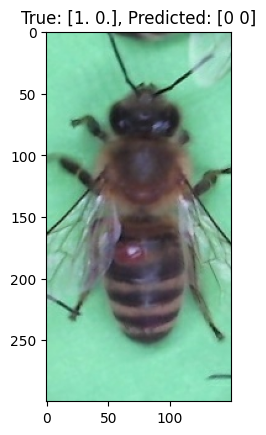

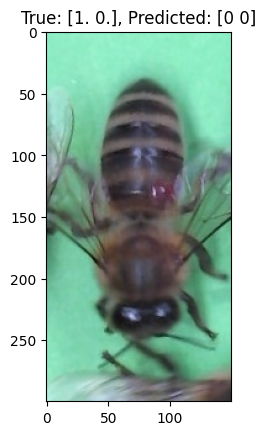

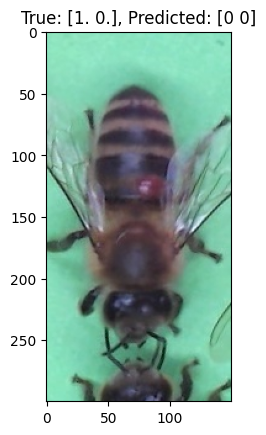

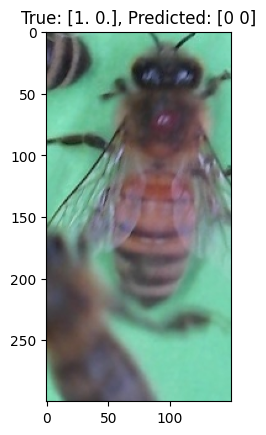

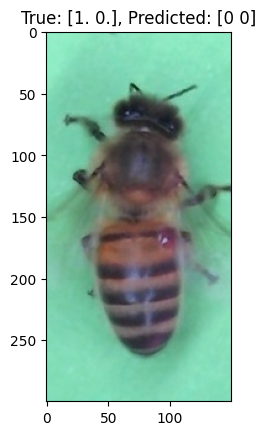

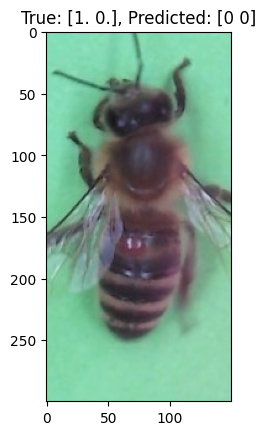

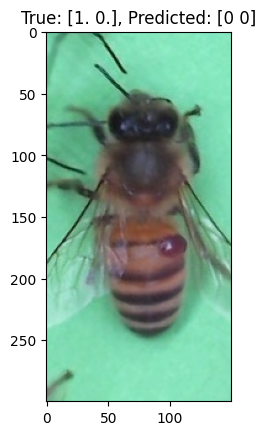

In [38]:
# Display first N incorrect images
N = 18
for i in range(min(N, len(incorrect_images))):
    plt.imshow(incorrect_images[i])
    plt.title(f"True: {incorrect_labels[i]}, Predicted: {incorrect_predictions[i]}")
    plt.show()

There definitely seems to be improvment from the focal loss although this could also just be which epoch the v1 model landed on seeing how big the performance difference is. I feel like I'm noticing a trend in the error pictures where the ones it's having a hard time teeling apart are where the mite appears darker and the ones where it thinks there's a mite there even though there isn't seem to have a red tinge to the photo. I think the model might (pun unintended) be cheating by depending too heavily on the colour. To confirm first though I'll try to see where the model is focusing for these incorrect predictions. 

## Prediction Explanations <a class="anchor" id="prediction-explanations"></a>

In [39]:
for images, labels in val.take(1):
    break  # This will give us the first batch

1/1 [==============================] - 0s 493ms/step
[[0.4080673  0.01358216]]


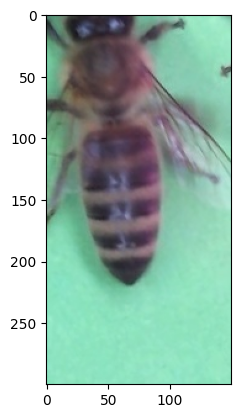

In [40]:
single_image = images[17]
input_image = tf.expand_dims(single_image, axis=0)
plt.imshow(single_image)
pred = model_v1.predict(input_image)
print(pred)

In [32]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [33]:
import matplotlib.cm as cm
from IPython.display import Image, display

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.8):
    # Load the original image
    # img = keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

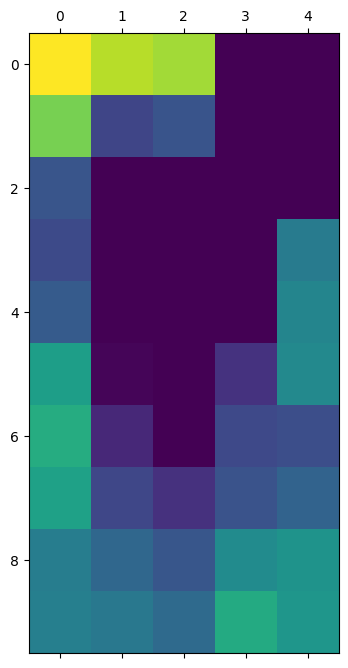

In [43]:
last_conv_layer_name = "BlockGroup5__block_3__conv_3"
last_conv_layer = model_v1.get_layer(last_conv_layer_name)


heatmap = make_gradcam_heatmap(input_image, model_v1, last_conv_layer_name, pred_index=0)

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_29814/4207377605.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


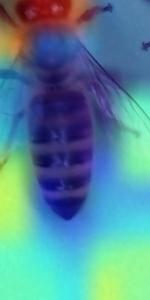

In [44]:
save_and_display_gradcam(single_image, heatmap)

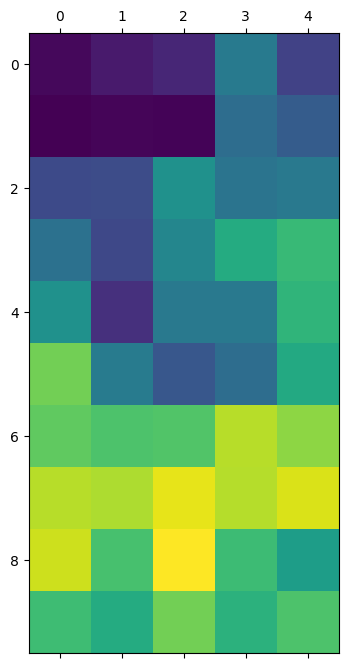

In [45]:
# Using index 1 for output
heatmap = make_gradcam_heatmap(input_image, model_v1, last_conv_layer_name, pred_index=1)

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_29814/4207377605.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


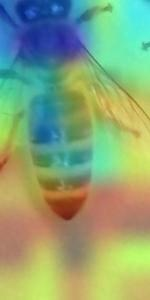

In [46]:
save_and_display_gradcam(single_image, heatmap)

After looking at a few examples it seems that the model isn't really cluing into the varroa output, and it seems like it might be making it's predictions on something other than the actual area of the image with the varroa in it. Let's see if we can get better performance with some augmentations.

# Image Augmentation <a class="anchor" id="image-augmentation"></a>

In [52]:
import tensorflow_addons as tfa

def augment_image(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly adjust the brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Randomly rotate the image
    angle = np.random.uniform(-15, 15)  # Rotation angle
    angle = np.deg2rad(angle)  # Convert to radians
    image = tfa.image.rotate(image, angle)

    # Randomly zoom the image
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
    def random_zoom(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(300, 150))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    image = random_zoom(image)

    return image, label

def augment_image_multiple_versions(image, label):
    num_versions = 6
    # Create a list to store augmented versions
    augmented_images = []
    augmented_labels = []

    for _ in range(num_versions):  # num_versions is the number of augmented versions you want
        augmented_image, _ = augment_image(image, label)
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

    return tf.stack(augmented_images), tf.stack(augmented_labels)

/home/spencer/vscode/VarroaClassifier/.venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [53]:
augmented_train = train.unbatch().map(augment_image_multiple_versions).unbatch()

In [54]:
augmented_train = augmented_train.shuffle(10000).batch(32)

# Model v2 <a class="anchor" id="model-v2"></a>

## Train <a class="anchor" id="train3"></a>

In [ ]:
from tensorflow.keras.losses import BinaryFocalCrossentropy

# Load the pre-trained ResNetRS350 model
base_model = tf.keras.applications.resnet_rs.ResNetRS350(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 150, 3)
)

# Freeze the layers of the base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units
predictions = Dense(2, activation='sigmoid')(x)  # 2 units for binary classification

# Create the final model
model_v2 = Model(inputs=base_model.input, outputs=predictions)

focal_loss = BinaryFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=False)

# Compile the model
model_v2.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model_v2.fit(augmented_train, validation_data=val, epochs=30, callbacks=[callback], verbose=1)

In [ ]:
model_v2.save('models/model_v2')

## Load

In [47]:
model_v2 = tf.keras.models.load_model('models/model_v2')

## Results <a class="anchor" id="results3"></a>

In [48]:
y_true, y_pred = get_predictions(model_v2, val, 0.5)

incorrect = np.sum(y_pred != y_true)
print(f"Total Incorrect Predictions: {incorrect}/{np.shape(y_pred)[0]}")

1/1 [==============================] - 6s 6s/step
Total Incorrect Predictions: 27/749


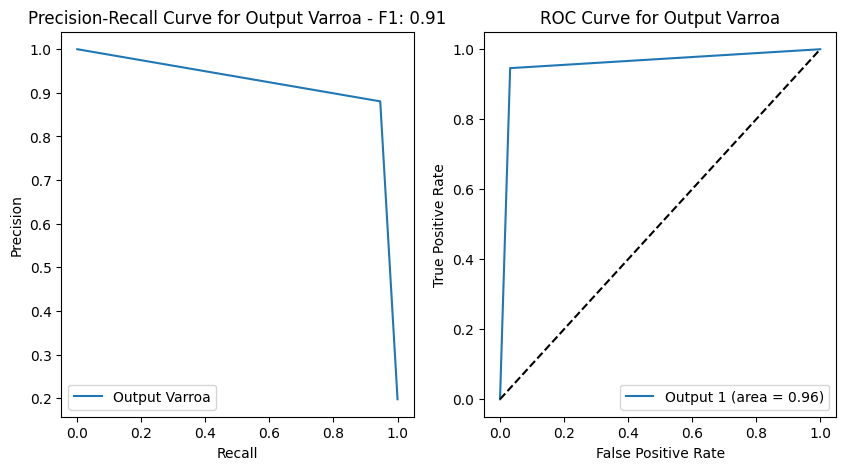

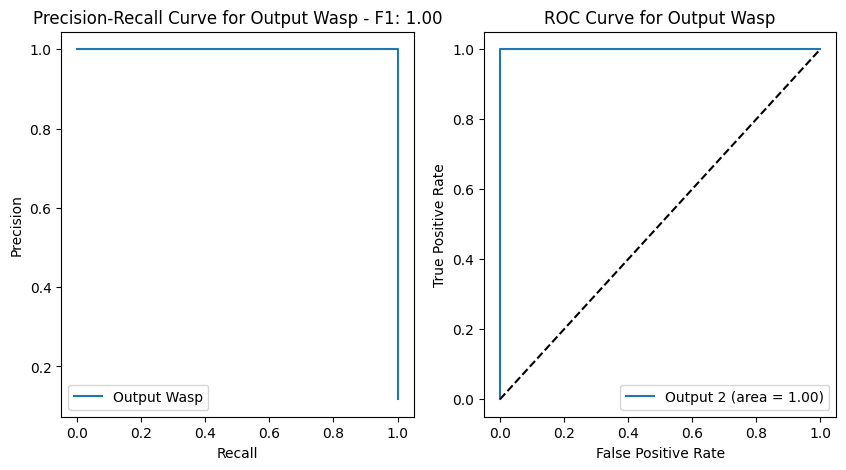

In [49]:
output_list = ['Varroa', 'Wasp']
# Calculate metrics for each output
for i in range(2):
    # Precision, Recall, and F1 Score
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    f1 = f1_score(y_true[:, i], np.round(y_pred[:, i]))

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    # Visualization
    plt.figure(figsize=(10, 5))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'Output {output_list[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Output {output_list[i]} - F1: {f1:.2f}')
    plt.legend(loc="lower left")

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'Output {i+1} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Output {output_list[i]}')
    plt.legend(loc="lower right")

    plt.show()

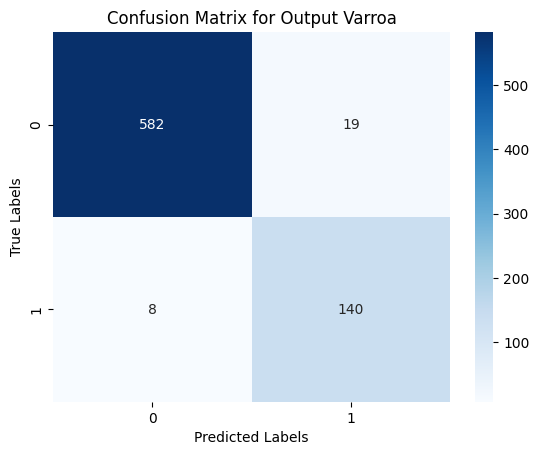

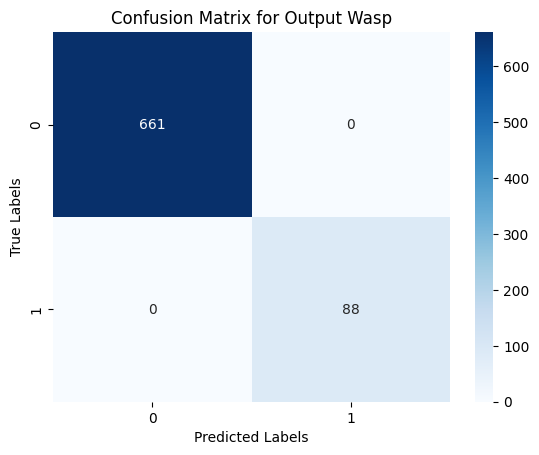

In [50]:
for i in range(2):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Output {output_list[i]}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

2023-11-17 16:22:23.650276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:2101: Filling up shuffle buffer (this may take a while): 5779 of 10000
2023-11-17 16:22:31.064336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


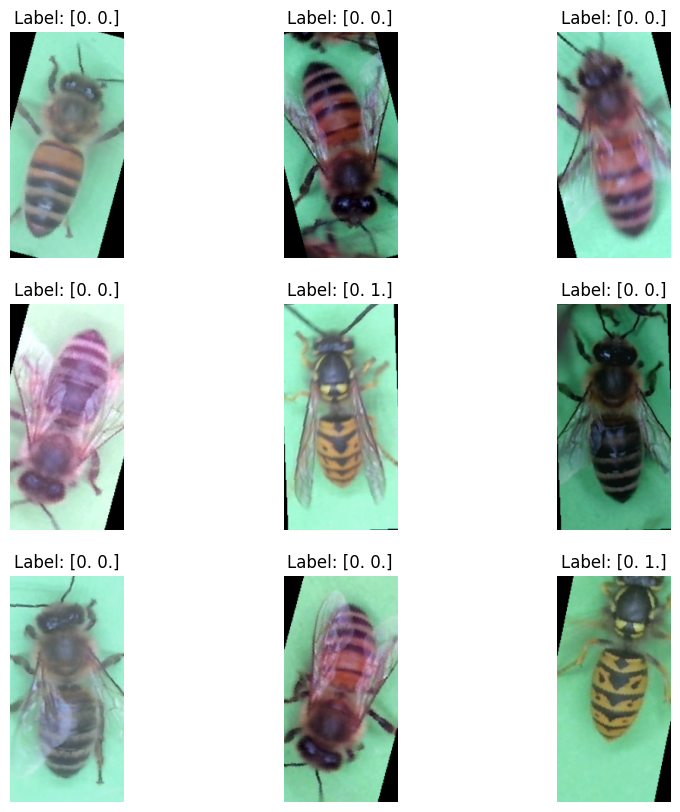

In [55]:
for images, labels in augmented_train.take(1):

    plt.figure(figsize=(10, 10))  # Set the figure size

    # Display the first N images in the batch
    N = 9  # Number of images to display
    for i in range(N):
        plt.subplot(3, 3, i + 1)  # Create a subplot for each image

        # Extract the i-th image from the batch
        image = images[i].numpy()

        # If necessary, convert the image data to a displayable format
        # For example, if the images are stored as integers in the range [0, 255]:
        image = image.astype("float32") / 255

        plt.imshow(image)  # Display the image
        plt.title(f"Label: {labels[i].numpy()}")  # Optionally, display the label
        plt.axis("off")  # Turn off axis

    plt.show()

# Reflection checkpoint <a class="anchor" id="reflection-checkpoint"></a>
At this point we've tried a simple baseline with a custom trained head, an alternate loss function, and a model trained on an augmented dataset. There's two explorations avenues I can go from here:
 - Ensemble with voting
 - Fine tuning the final layer of the ResNet model

I think the second option is the most promising based on [this article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) about training classifier networks on small datasets. In the article they go from 90% to 94% accuracy by fine-tuning the final bloack so we'll try the same approach. Theoretically we should see an imporvement in the GradCAM results from this.

We'll try that with the non-augmented dataset, and if it shows promise we'll continue down that path, and if the performance is the same we'll switch to trying an ensemble with voting.

# Model v2.1 <a class="anchor" id="model-v2.1"></a>

## Train <a class="anchor" id="train4"></a>

In [56]:
layers = [layer.name for layer in model_v2.layers]
print(layers)

['input_1', 'rescaling', 'normalization', 'zero_padding2d', 'stem_1_stem_conv_1', 'stem_1_stem_batch_norm_1', 'stem_1_stem_act_1', 'stem_1_stem_conv_2', 'stem_1_stem_batch_norm_2', 'stem_1_stem_act_2', 'stem_1_stem_conv_3', 'stem_1_stem_batch_norm_3', 'stem_1_stem_act_3', 'zero_padding2d_1', 'stem_1_stem_conv_4', 'stem_1_stem_batch_norm_4', 'stem_1_stem_act_4', 'BlockGroup2__block_0__conv_1', 'BlockGroup2__block_0_batch_norm_1', 'BlockGroup2__block_0__act_1', 'BlockGroup2__block_0__conv_2', 'BlockGroup2__block_0__batch_norm_2', 'BlockGroup2__block_0__act_2', 'BlockGroup2__block_0__conv_3', 'BlockGroup2__block_0__batch_norm_3', 'BlockGroup2__block_0__se_se_squeeze', 'BlockGroup2__block_0__se_se_reshape', 'BlockGroup2__block_0__se_se_reduce', 'BlockGroup2__block_0__se_se_expand', 'BlockGroup2__block_0__se_se_excite', 'BlockGroup2__block_0__projection_conv', 'BlockGroup2__block_0__drop', 'BlockGroup2__block_0__projection_batch_norm', 'add', 'BlockGroup2__block_0__output_act', 'BlockGroup2

In [57]:
start_unfreezing = False

for layer in model_v2.layers:
    if layer.name == 'BlockGroup5__block_0__conv_1':
        start_unfreezing = True
    if start_unfreezing:
        layer.trainable = True
    else:
        layer.trainable = False

In [60]:
# Recompile the model after unfreezing
model_v2.compile(optimizer='adam', loss=focal_loss, metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model_v2.fit(train, validation_data=val, epochs=30, callbacks=[callback], verbose=1)

In [ ]:
model_v2.save('models/model_v2.1')

## Load

In [20]:
model_v2 = tf.keras.models.load_model('models/model_v2.1')

## Results <a class="anchor" id="results4"></a>

In [23]:
y_true, y_pred = get_predictions(model_v2, val, 0.5)

incorrect = np.sum(y_pred != y_true)
print(f"Total Incorrect Predictions: {incorrect}/{np.shape(y_pred)[0]}")

2023-11-17 16:36:14.678892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


1/1 [==============================] - 4s 4s/step
Total Incorrect Predictions: 0/749


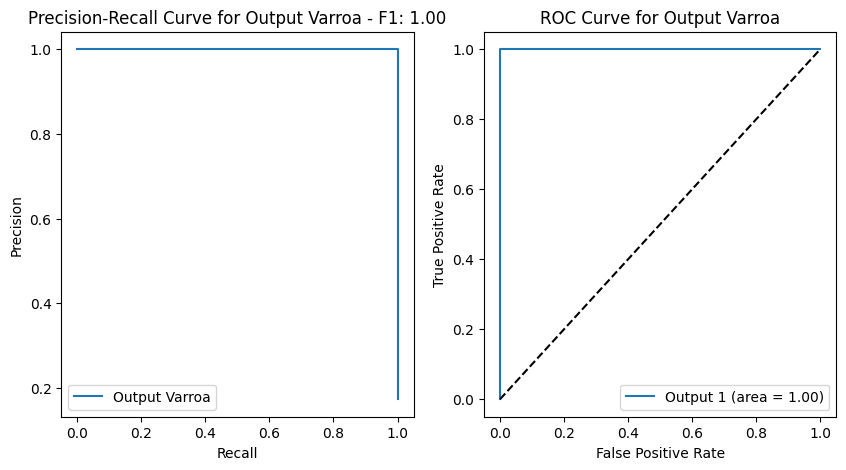

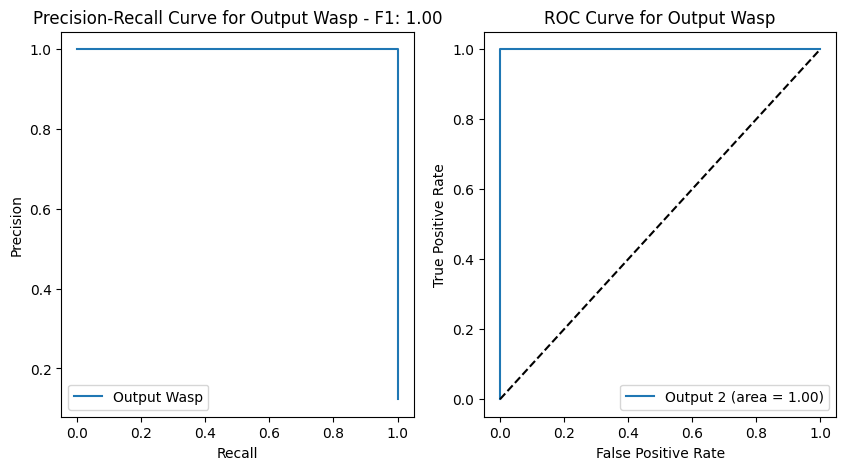

In [24]:
output_list = ['Varroa', 'Wasp']
# Calculate metrics for each output
for i in range(2):
    # Precision, Recall, and F1 Score
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    f1 = f1_score(y_true[:, i], np.round(y_pred[:, i]))

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    # Visualization
    plt.figure(figsize=(10, 5))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'Output {output_list[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Output {output_list[i]} - F1: {f1:.2f}')
    plt.legend(loc="lower left")

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'Output {i+1} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Output {output_list[i]}')
    plt.legend(loc="lower right")

    plt.show()

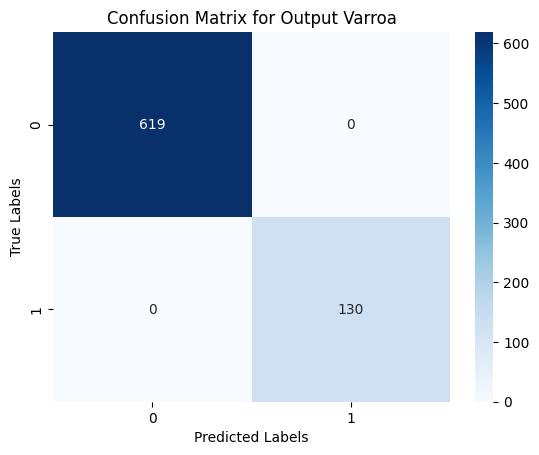

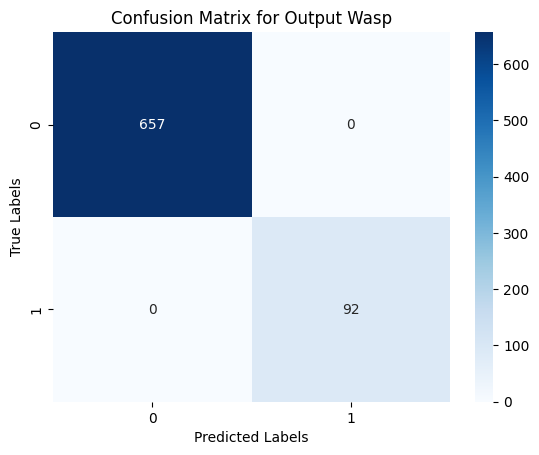

In [25]:
for i in range(2):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Output {output_list[i]}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

This seems a little too good, I'm a little worried we've overfitted to the validation set...

In [26]:
y_true, y_pred = get_predictions(model_v2, train, 0.5)

incorrect = np.sum(y_pred != y_true)
print(f"Total Incorrect Predictions: {incorrect}/{np.shape(y_pred)[0]}")

1/1 [==============================] - 0s 305ms/step
Total Incorrect Predictions: 2/5992


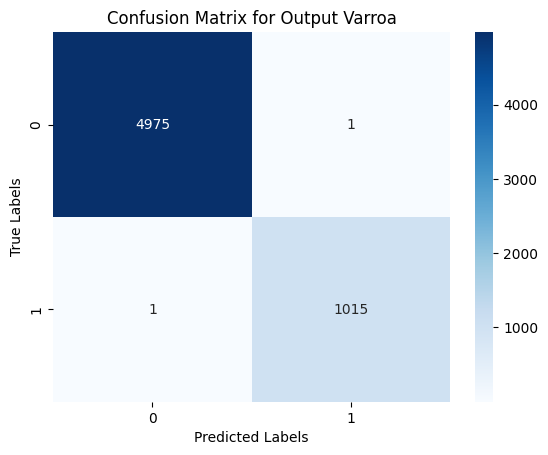

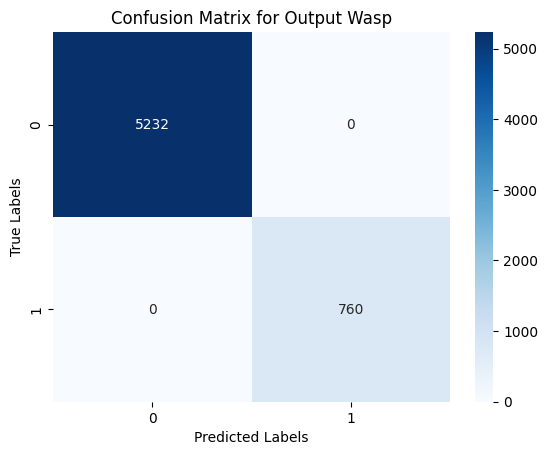

In [27]:
for i in range(2):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Output {output_list[i]}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [29]:
for images, labels in val.take(1):
    break  # This will give us the first batch

1/1 [==============================] - 0s 133ms/step
[[9.8157287e-01 2.8240056e-08]]


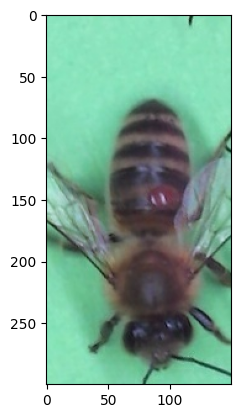

In [38]:
single_image = images[1]
input_image = tf.expand_dims(single_image, axis=0)
plt.imshow(single_image)
pred = model_v2.predict(input_image)
print(pred)

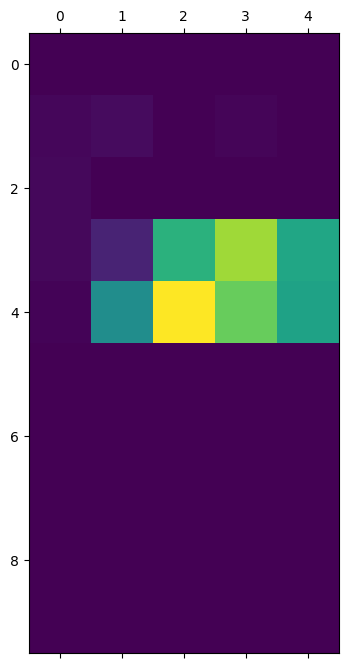

In [39]:
last_conv_layer_name = "BlockGroup5__block_3__conv_3"
last_conv_layer = model_v2.get_layer(last_conv_layer_name)


heatmap = make_gradcam_heatmap(input_image, model_v2, last_conv_layer_name, pred_index=0)

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_35862/4207377605.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


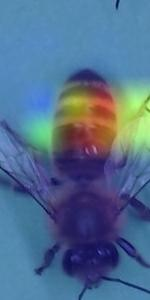

In [40]:
save_and_display_gradcam(single_image, heatmap)

In [41]:
batch_size=32
test = test.map(extract_features).batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
y_true, y_pred = get_predictions(model_v2, test, 0.5)

incorrect = np.sum(y_pred != y_true)
print(f"Total Incorrect Predictions: {incorrect}/{np.shape(y_pred)[0]}")

1/1 [==============================] - 0s 62ms/step
Total Incorrect Predictions: 0/749


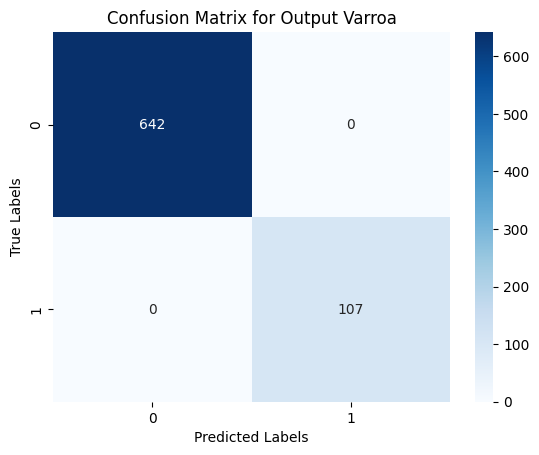

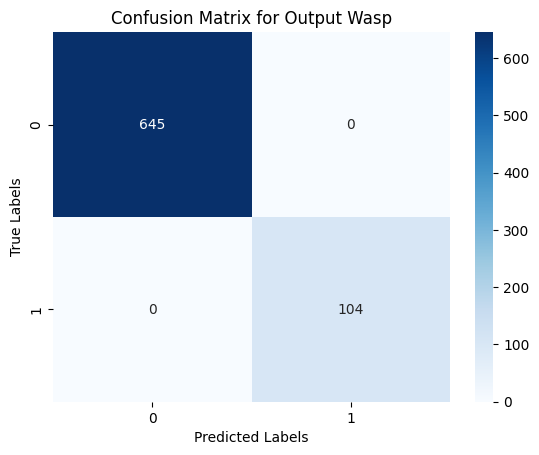

In [43]:
for i in range(2):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Output {output_list[i]}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Reflections

In hindsight I probably should have started with the fine tuning before doing the augmentation since the model clearly was not paying attention to the bee itself. This makes sense since ResNet is trained for identificaiton of objects (example tiger or no tiger) but not necessarily objects that are part of other objects. For this reason, fine tuning the actual base network makes a lot of sense and should have been done right after I saw the GradCAM results.

If doing this in a less time-restricted setting I would have taken the time to set up model/training tracking on something like mlflow and dataset tracking using DVC. On that note, I probably would have taken some time to explore other libraries for handling the dataset as tensorflows is not the best documented when it comes to hnadling shuffling with caching and I did get some weird errors a few times. This might also be because I didn't download the dataset and read from storage but simply kept it in memory and pulled each time the notebook was run.

With more time I would also focus more on model robustness and dataset augmentation/processing. Luckily the model accepted images in the dimensions I had them. I was able to do a bit of augmentation but I would take this much further with roations of any angle and also some image rescaling that affected the ratio slightly:)